In [2]:
# Getting Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

ModuleNotFoundError: No module named 'xgboost'

In [1]:
# Load datasets
train_data = pd.read_csv('/train.csv')
meal_info = pd.read_csv('/meal_info.csv')
center_info = pd.read_csv('/fulfilment_center_info.csv')

NameError: name 'pd' is not defined

In [ ]:
# Merge datasets for a consolidated view
full_data = train_data.merge(meal_info, on='meal_id', how='left')
full_data = full_data.merge(center_info, on='center_id', how='left')

In [ ]:
# EDA Functions
def plot_distributions(data, variables, titles):
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 5))
    for i, var in enumerate(variables):
        plt.subplot(1, 3, i+1)
        sns.histplot(data[var], bins=50, kde=True)
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()

def plot_weekly_orders(data):
    weekly_orders = data.groupby('week')['num_orders'].sum().reset_index()
    sns.lineplot(x='week', y='num_orders', data=weekly_orders)
    plt.title('Trend of Total Orders Over Weeks')
    plt.show()

def plot_promotion_impact(data, promotion_features):
    for feature in promotion_features:
        sns.boxplot(x=feature, y='num_orders', data=data)
        plt.title(f'Impact of {feature} on Orders')
        plt.show()

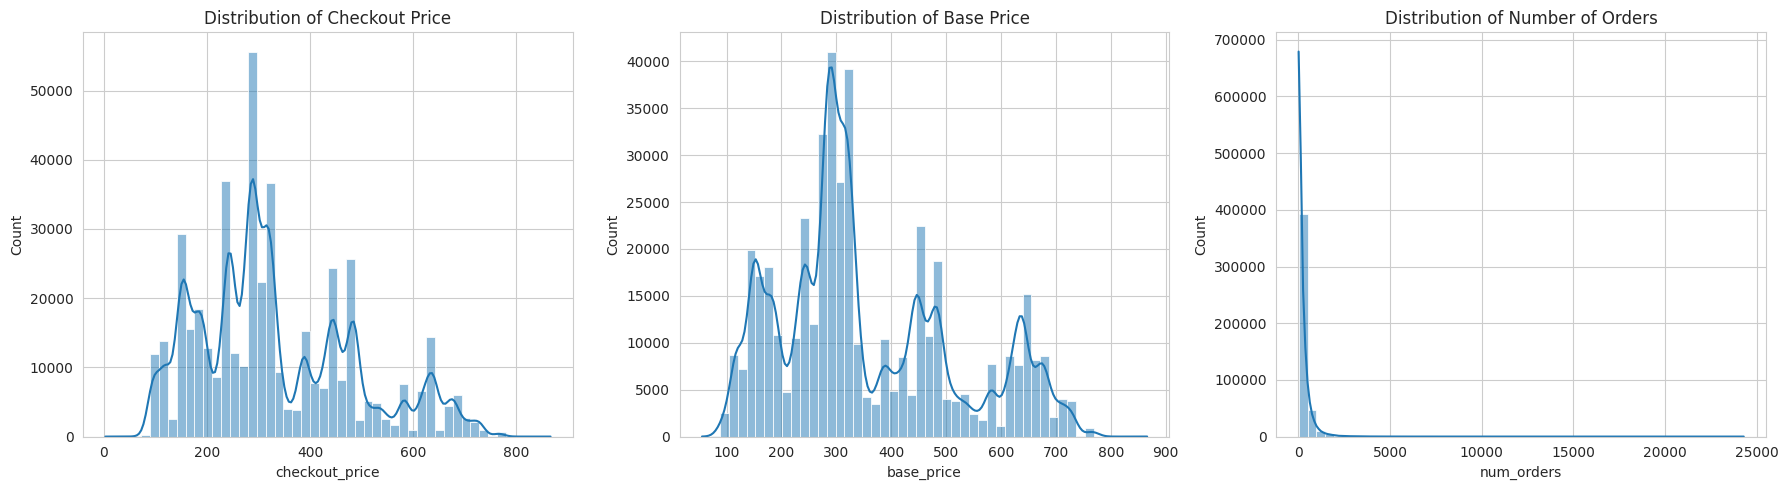

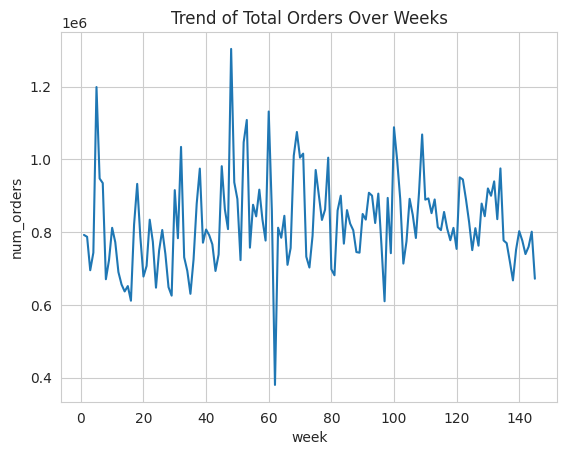

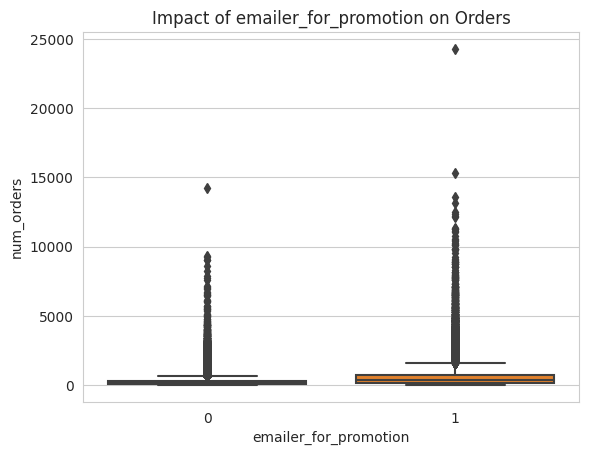

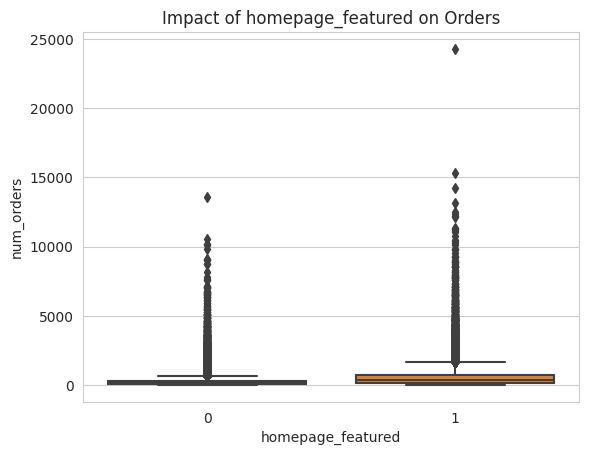

In [ ]:
# EDA Execution
variables_to_plot = ['checkout_price', 'base_price', 'num_orders']
titles = ['Distribution of Checkout Price', 'Distribution of Base Price', 'Distribution of Number of Orders']
plot_distributions(full_data, variables_to_plot, titles)
plot_weekly_orders(full_data)
promotion_features = ['emailer_for_promotion', 'homepage_featured']
plot_promotion_impact(full_data, promotion_features)

In [ ]:
# Data Preparation
label_encoders = {}
categorical_columns = ['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 'category', 'cuisine', 'city_code', 'region_code', 'center_type']
for column in categorical_columns:
    le = LabelEncoder()
    full_data[column] = le.fit_transform(full_data[column])
    label_encoders[column] = le

# Create lag features
for week_lag in [1, 2, 3, 4, 5]:
    full_data[f'lag_{week_lag}'] = full_data.groupby(['center_id', 'meal_id'])['num_orders'].shift(week_lag)

# Removing NA values
full_data = full_data.dropna()

In [ ]:
# Split data into train and validation sets
features = ['week', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'op_area', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'center_id', 'meal_id', 'category', 'cuisine', 'city_code', 'region_code', 'center_type']
target = 'num_orders'
X_train, X_val, y_train, y_val = train_test_split(full_data[features], full_data[target], test_size=0.2, random_state=42)

In [ ]:
# Model Building: XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, early_stopping_rounds=50, random_state=42, n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Model Evaluation: XGBoost
y_val_pred = xgb_model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"XGBoost - Mean Absolute Error (MAE): {mae}")
print(f"XGBoost - Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:38:58] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:38:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost - Mean Absolute Error (MAE): 69.54436669412402
XGBoost - Root Mean Squared Error (RMSE): 138.71528187730752


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:39:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:39:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
!sudo apt-get install opencl-headers opencl-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'ocl-icd-opencl-dev' instead of 'opencl-dev'
ocl-icd-opencl-dev is already the newest version (2.2.14-3).
ocl-icd-opencl-dev set to manually installed.
The following NEW packages will be installed:
  opencl-headers
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 1,754 B of archives.
After this operation, 12.3 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 opencl-headers all 3.0~2022.01.04-1 [1,754 B]
Fetched 1,754 B in 0s (9,257 B/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debcon

LightGBM - Mean Absolute Error (MAE): 67.01909891186781
LightGBM - Root Mean Squared Error (RMSE): 129.0164929999109


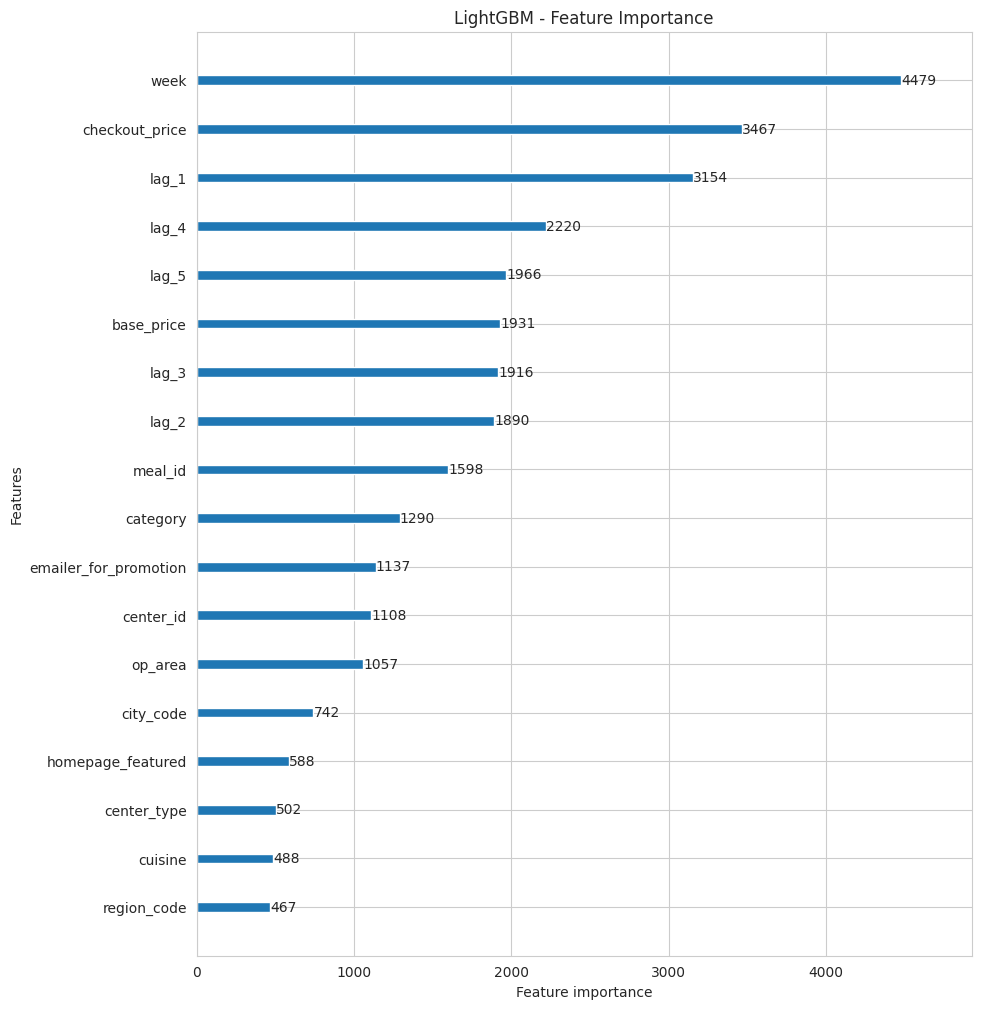

In [ ]:
# Model Building: LightGBM
import lightgbm as lgb
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'device': 'cpu',  # Use GPU
    'early_stopping_rounds': 50,  # Early stopping rounds directly in the params
    'verbose_eval': False  # Use verbose_eval directly in the params
}
num_round = 1000
lgb_model = lgb.train(params, train_dataset, num_round, valid_sets=[val_dataset])

# Model Evaluation: LightGBM
y_val_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
mae_lgb = mean_absolute_error(y_val, y_val_pred_lgb)
rmse_lgb = mean_squared_error(y_val, y_val_pred_lgb, squared=False)
print(f"LightGBM - Mean Absolute Error (MAE): {mae_lgb}")
print(f"LightGBM - Root Mean Squared Error (RMSE): {rmse_lgb}")

# Plotting feature importance for LightGBM
lgb.plot_importance(lgb_model, importance_type='split', figsize=(10, 12), max_num_features=20)
plt.title("LightGBM - Feature Importance")
plt.show()


In [ ]:
!sudo apt-get install ocl-icd-opencl-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ocl-icd-opencl-dev is already the newest version (2.2.14-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
# SARIMA model
weekly_orders_sarima = full_data.groupby('week')['num_orders'].sum().reset_index()
train_data_sarima = weekly_orders_sarima.iloc[:-10]
test_data_sarima = weekly_orders_sarima.iloc[-10:]
sarima_model = sm.tsa.statespace.SARIMAX(train_data_sarima['num_orders'],
                                         order=(1, 1, 1),
                                         seasonal_order=(1, 1, 1, 52),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
results = sarima_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
# SARIMA Forecast
forecast = results.get_forecast(steps=10).predicted_mean
test_weeks = test_data_sarima['week']
actual_values = test_data_sarima['num_orders']

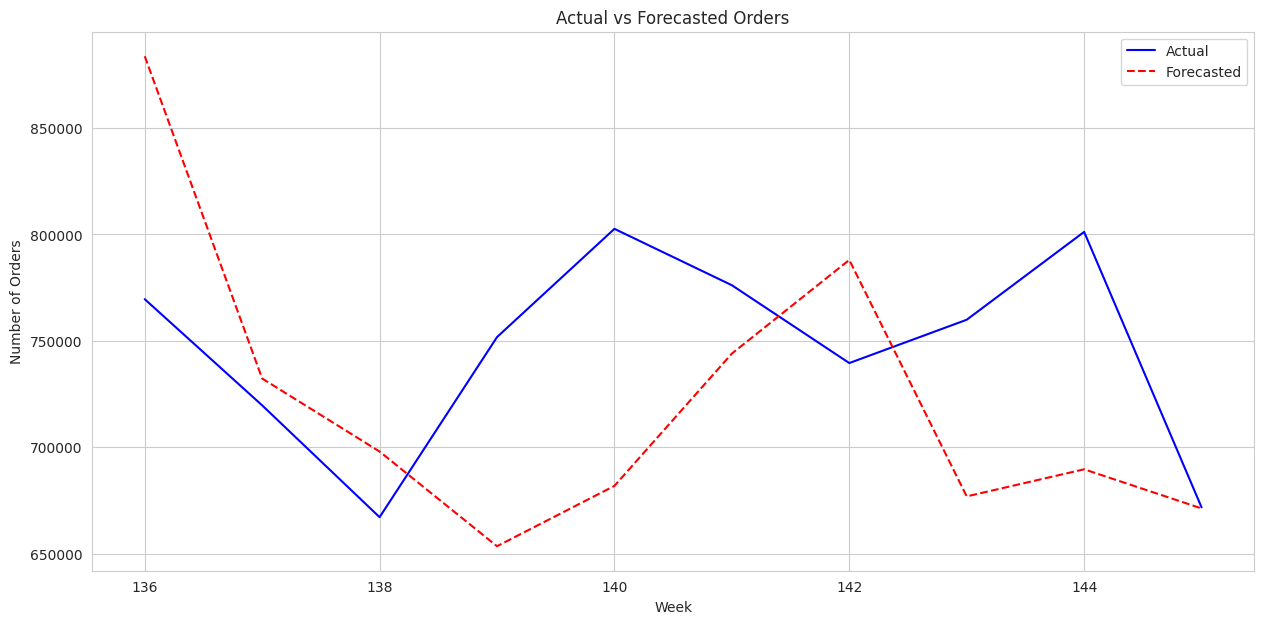

In [ ]:
# Plotting SARIMA results
plt.figure(figsize=(15,7))
plt.plot(test_weeks, actual_values, label='Actual', color='blue')
plt.plot(test_weeks, forecast, label='Forecasted', color='red', linestyle='--')
plt.title('Actual vs Forecasted Orders')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

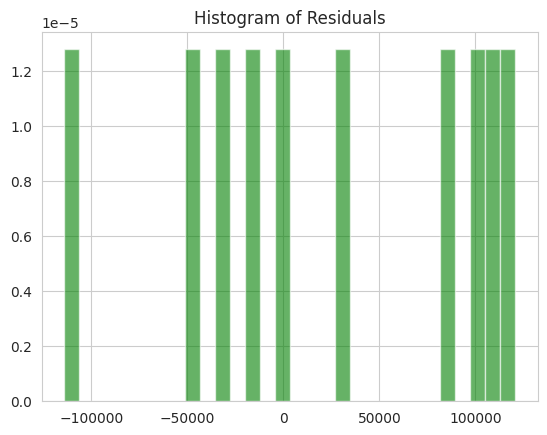

In [ ]:
# Residual analysis
residuals = actual_values - forecast
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
plt.title("Histogram of Residuals")
plt.show()

In [ ]:
# Skewness and Kurtosis
res_skewness = skew(residuals)
res_kurtosis = kurtosis(residuals)
print(f"Skewness of Residuals: {res_skewness}")
print(f"Kurtosis of Residuals: {res_kurtosis}")

Skewness of Residuals: -0.2560934896124127
Kurtosis of Residuals: -1.0658780626338795
